In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import yaml
import shutil
from datetime import datetime

sns.set_theme()

In [5]:
### All global variables that would be passed as arguments in a python script
micro_benchmarks_data = "/home/nils/Documents/TU_Berlin/Work_DIMA/NES/nebulastream-public/window_management/benchmark_scripts/micro-benchmarks-data"
input_csv_file = f"{micro_benchmarks_data}/benchmark_task_size_180142.csv"
output_folder_plots = f"{micro_benchmarks_data}"


In [6]:
def parse_line(name_value):
    parts = name_value.split('/')
    if len(parts) < 6:
        return pd.Series({
            "No. Tuples": None,
            "No. Tuples / Task": None,
            "Sleep / Tup" : None,
            "Selectivity": None,
            "Provider": None,
            "No. Threads": None
        })
    return pd.Series({
        "No. Tuples / Task": parts[2],
        "Sleep / Tup" : parts[3],
        "Selectivity": parts[4],
        "Provider": parts[5],
        "No. Threads": parts[6]
    })

def load_data(filename):
    df = pd.read_csv(filename)
    df = remove_rows(df)
    df_new = df.join(df["name"].apply(parse_line))
    df_new = convert_to_seconds(df_new)

    # Calculating some useful statistics
    for col in ["Provider", "No. Threads", "Sleep / Tup", "No. Tuples / Task", "Number_Of_Tasks"]:
        df_new[col] = pd.to_numeric(df_new[col], errors='ignore')
    time_unit = df_new.iloc[0]['time_unit']
    df_new['No. Tasks'] = df_new['Number_Of_Tasks']
    df_new['No. Tuples'] = df_new['Tuples_Processed']
    df_new["tuples_per_sec"] = df_new["No. Tuples"] / df_new["real_time_sec"]
    df_new = df_new.sort_values(by=['No. Tuples / Task'])
    #df_new['sub_left_side'] = df_new['real_time_ms'] * 1000
    #df_new['sub_right_side'] = ((df_new['Sleep / Tup'] / 1000) * df_new['No. Tuples']) / df_new['No. Threads']
    #df_new['time_extra_us'] = df_new['sub_left_side'] - df_new['sub_right_side']
    #df_new['time_extra_ms'] = df_new['time_extra_us'] / 1000
    #df_new['time_extra_ms_per_tuple'] = df_new['time_extra_ms'] / df_new['No. Tuples']
    #df = df[df['time_extra'] >= 0]

    # Dropping some columns
    columns_to_drop=['error_message', 'error_occurred', 'label', 'cpu_time', 'Thread_0_Processed_Tuples', 'items_per_second', 'bytes_per_second']
    df_new.drop(columns=columns_to_drop, inplace=True)
    return df_new

# Removing all rows that end in "_stddev", "_median", "_mean", "_cv"
def remove_rows(df):
    suffix_list = ["_stddev", "_median", "_mean", "_cv"]
    target_column = 'name'
    df[target_column] = df[target_column].astype(str)
    mask = df[target_column].str.endswith(tuple(suffix_list))
    df_filtered = df[~mask]
    return df_filtered

def convert_to_seconds(df):
    """Adds a new column 'real_time_sec' to df, converting 'real_time' based on 'time_unit'."""
    time_multipliers = {
        "ns": 1e-9,  # Nanoseconds to seconds
        "us": 1e-6,  # Microseconds to seconds
        "ms": 1e-3,  # Milliseconds to seconds
        "s": 1,      # Seconds (no change)
        "sec": 1     # Alternate label for seconds
    }
    
    df["real_time_sec"] = df["real_time"] * df["time_unit"].map(time_multipliers)
    df["real_time_ms"] = df["real_time_sec"] * 1000
    return df

# Load data into dataframe and then remove rows
df = load_data(input_csv_file)

if df.empty:
    print("No data loaded; check the input file format.")
    sys.exit(1)

df

/tmp/ipykernel_66885/2624324609.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_new[col] = pd.to_numeric(df_new[col], errors='ignore')


,name,iterations,real_time,time_unit,Number_Of_Tasks,Tuples_Processed,No. Tuples / Task,Sleep / Tup,Selectivity,Provider,No. Threads,real_time_sec,real_time_ms,No. Tasks,No. Tuples,tuples_per_sec
0,NES::BM_SleepPipeline/100000000/1/100/0/1/1/it...,1,28941.700,ms,100000000.0,100000000.0,1,100,0,1,1,28.941700,28941.700,100000000.0,100000000.0,3.455222e+06
1765,NES::BM_SleepPipeline/100000000/1/100/30/1/8/i...,1,57024.700,ms,100000000.0,100000000.0,1,100,30,1,8,57.024700,57024.700,100000000.0,100000000.0,1.753626e+06
1766,NES::BM_SleepPipeline/100000000/1/100/30/1/8/i...,1,64394.600,ms,100000000.0,100000000.0,1,100,30,1,8,64.394600,64394.600,100000000.0,100000000.0,1.552925e+06
2354,NES::BM_SleepPipeline/100000000/1/100/40/1/16/...,1,72919.600,ms,100000000.0,100000000.0,1,100,40,1,16,72.919600,72919.600,100000000.0,100000000.0,1.371373e+06
2353,NES::BM_SleepPipeline/100000000/1/100/40/1/16/...,1,81881.100,ms,100000000.0,100000000.0,1,100,40,1,16,81.881100,81881.100,100000000.0,100000000.0,1.221283e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,NES::BM_SleepPipeline/100000000/3000/100/60/1/...,1,490.627,ms,33333.0,99999000.0,3000,100,60,1,1,0.490627,490.627,33333.0,99999000.0,2.038188e+08
337,NES::BM_SleepPipeline/100000000/3000/100/60/1/...,1,508.570,ms,33333.0,99999000.0,3000,100,60,1,1,0.508570,508.570,33333.0,99999000.0,1.966278e+08
336,NES::BM_SleepPipeline/100000000/3000/100/60/1/...,1,454.269,ms,33333.0,99999000.0,3000,100,60,1,1,0.454269,454.269,33333.0,99999000.0,2.201317e+08
876,NES::BM_SleepPipeline/100000000/3000/100/60/1/...,1,247.266,ms,33333.0,99999000.0,3000,100,60,1,2,0.247266,247.266,33333.0,99999000.0,4.044187e+08


/tmp/ipykernel_66885/2624324609.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_new[col] = pd.to_numeric(df_new[col], errors='ignore')
/tmp/ipykernel_66885/2950381674.py:6: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


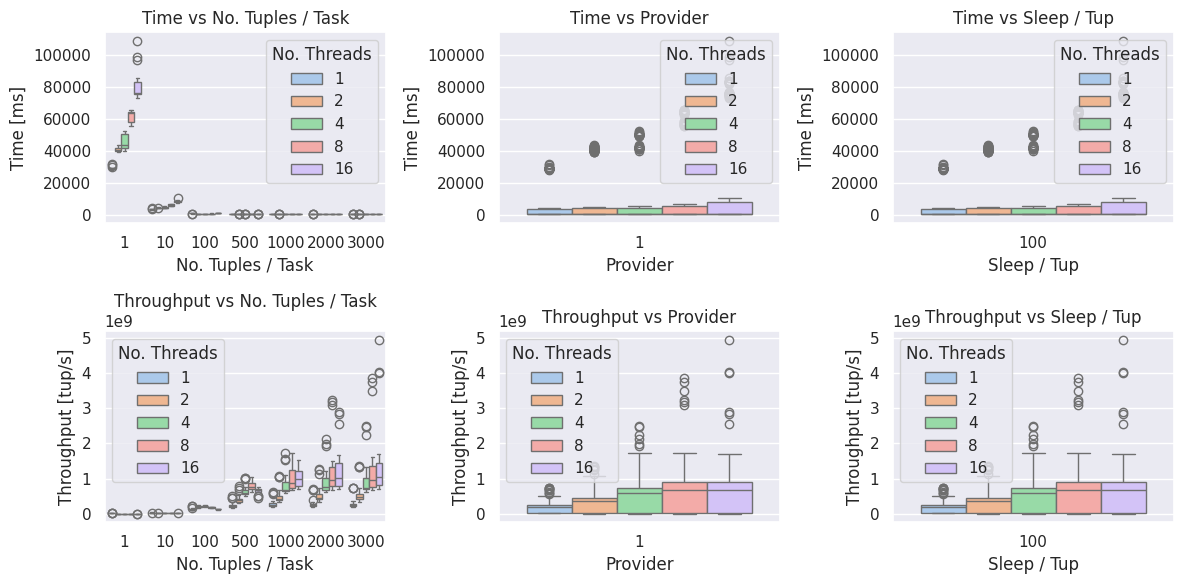

In [7]:
# Load data into dataframe and then plot different boxplots
df = load_data(input_csv_file)

interesting_params = ["No. Tuples / Task", "Provider", "Sleep / Tup"]
for col in interesting_params + ["No. Tuples", "Provider"]:
    df[col] = pd.to_numeric(df[col], errors='ignore')
time_unit = df.iloc[0]['time_unit']
df["tuples_per_sec"] = df["No. Tuples"] / df["real_time_sec"]


# Create a subplot grid.
n_params = len(interesting_params)
fig, axes = plt.subplots(2, n_params, figsize=(4*n_params, 6), squeeze=False)

for idx, param in enumerate(interesting_params):
    ax = axes[0][idx]
    sns.boxplot(x=param, y="real_time_ms", hue='No. Threads', data=df, ax=ax, palette="pastel")
    ax.set_title(f"Time vs {param}")
    ax.set_xlabel(param)
    ax.set_ylabel(f"Time [ms]")
    #ax.set_ylim([0, .04])

    ax = axes[1][idx]
    sns.boxplot(x=param, y="tuples_per_sec", hue='No. Threads', data=df, ax=ax, palette="pastel")
    ax.set_title(f"Throughput vs {param}")
    ax.set_xlabel(param)
    ax.set_ylabel(f"Throughput [tup/s]")

plt.tight_layout()
#plt.savefig(os.path.join(output_folder_plots, f"plots.png"))
plt.show()
plt.close()

/tmp/ipykernel_66885/2624324609.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_new[col] = pd.to_numeric(df_new[col], errors='ignore')


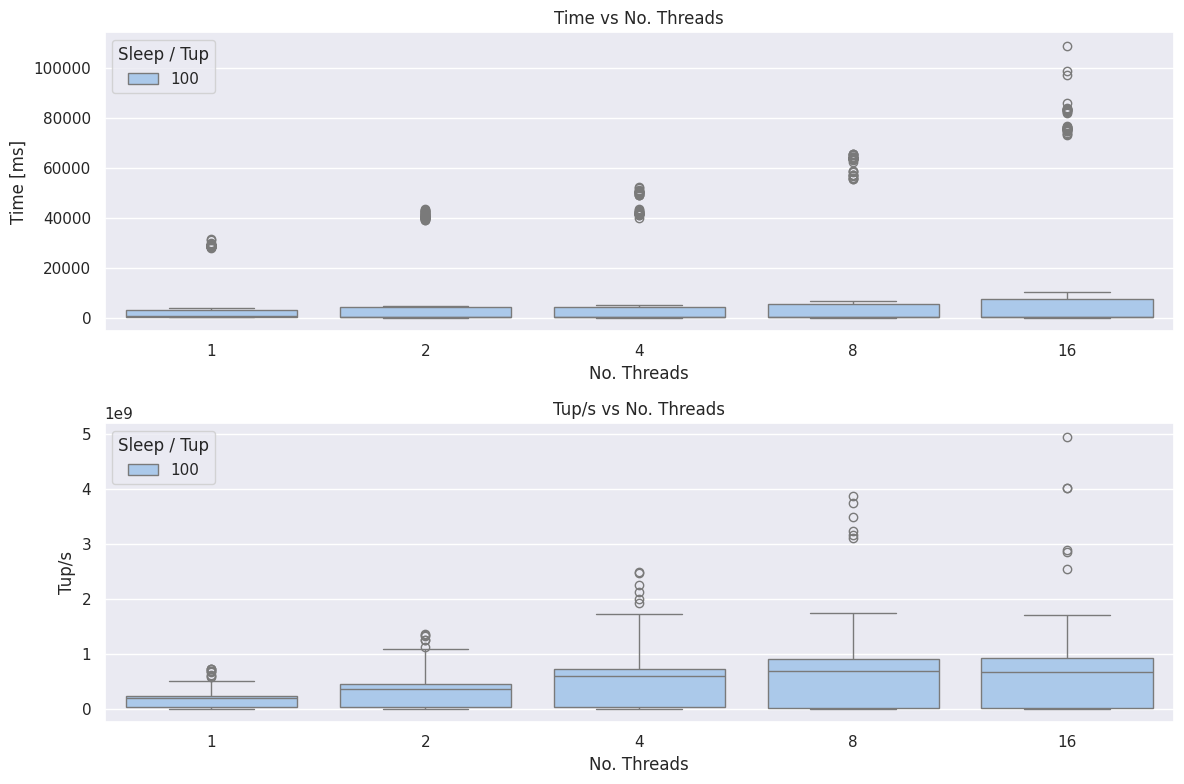

In [8]:
# Load data into dataframe and then plot different boxplots
df = load_data(input_csv_file)
interesting_params = ["No. Threads"]
time_unit = df.iloc[0]['time_unit']
df = df[df['Provider'] == 1]
                                           

# Create a subplot grid.
n_params = len(interesting_params)
fig, axes = plt.subplots(2, n_params, figsize=(12, 8), squeeze=False)

for idx, param in enumerate(interesting_params):
    ax = axes[0][idx]
    sns.boxplot(x=param, y="real_time_ms", hue='Sleep / Tup', data=df, ax=ax, palette="pastel")
    ax.set_title(f"Time vs {param}")
    ax.set_xlabel(param)
    ax.set_ylabel(f"Time [ms]")
    #ax.set_ylim([0, .04])

    ax = axes[1][idx]
    sns.boxplot(x=param, y="tuples_per_sec", hue='Sleep / Tup', data=df, ax=ax, palette="pastel")
    ax.set_title(f"Tup/s vs {param}")
    ax.set_xlabel(param)
    ax.set_ylabel(f"Tup/s")
    #ax.set_ylim(bottom=0)

plt.tight_layout()
#plt.savefig(os.path.join(output_folder_plots, f"plots.png"))
plt.show()
plt.close()

/tmp/ipykernel_66885/2624324609.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_new[col] = pd.to_numeric(df_new[col], errors='ignore')


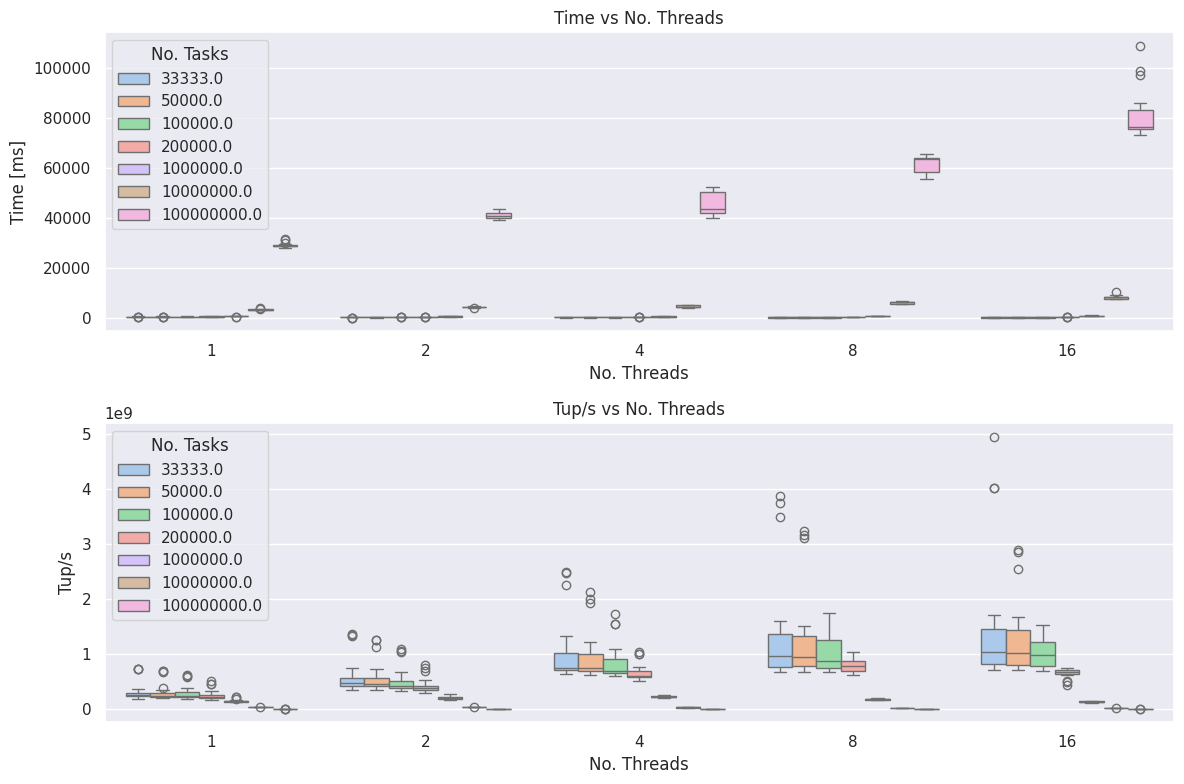

In [9]:
# Load data into dataframe and then plot different boxplots
df = load_data(input_csv_file)
interesting_params = ["No. Threads"]
time_unit = df.iloc[0]['time_unit']
df = df[df['Provider'] == 1]

                                           

# Create a subplot grid.
n_params = len(interesting_params)
fig, axes = plt.subplots(2, n_params, figsize=(12, 8), squeeze=False)

for idx, param in enumerate(interesting_params):
    ax = axes[0][idx]
    sns.boxplot(x=param, y="real_time_ms", hue='No. Tasks', data=df, ax=ax, palette="pastel")
    ax.set_title(f"Time vs {param}")
    ax.set_xlabel(param)
    ax.set_ylabel(f"Time [ms]")
    #ax.set_ylim([0, .04])

    ax = axes[1][idx]
    sns.boxplot(x=param, y="tuples_per_sec", hue='No. Tasks', data=df, ax=ax, palette="pastel")
    ax.set_title(f"Tup/s vs {param}")
    ax.set_xlabel(param)
    ax.set_ylabel(f"Tup/s")
    #ax.set_ylim(bottom=0)

plt.tight_layout()
#plt.savefig(os.path.join(output_folder_plots, f"plots.png"))
plt.show()
plt.close()

/tmp/ipykernel_66885/2624324609.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_new[col] = pd.to_numeric(df_new[col], errors='ignore')
/tmp/ipykernel_66885/756712160.py:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[interesting_param] = pd.to_numeric(df[interesting_param], errors='ignore')


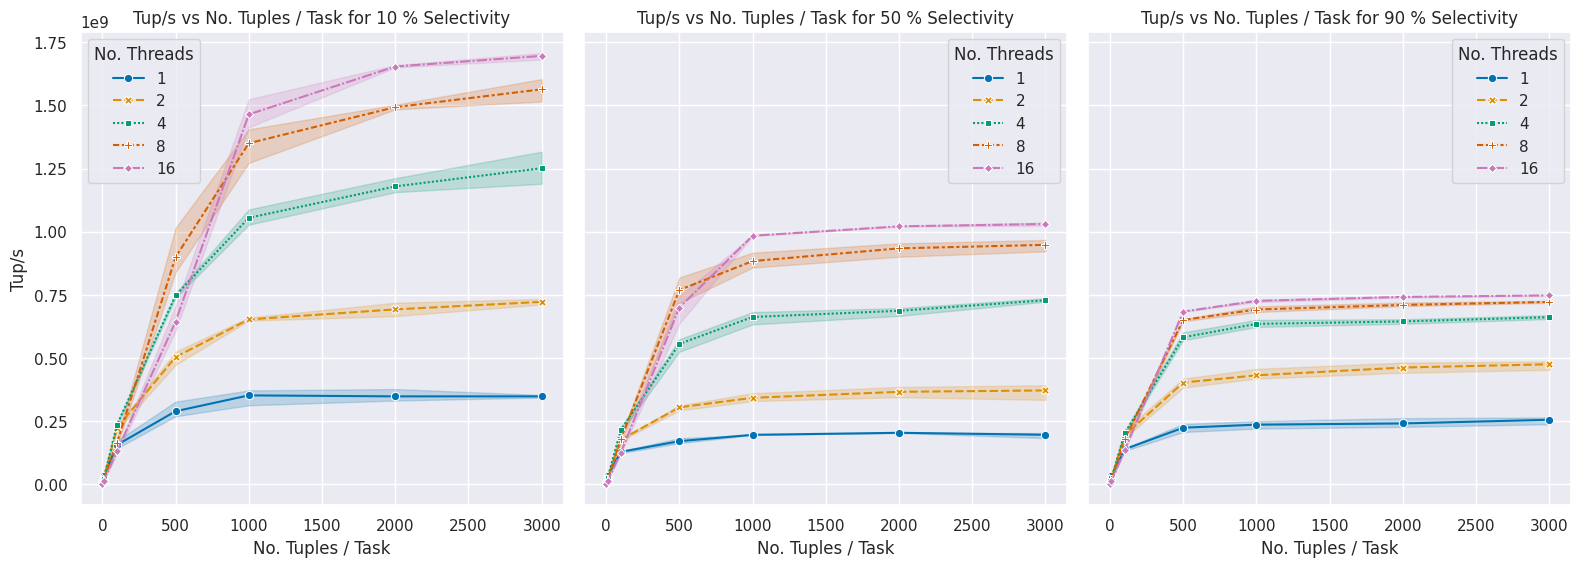

In [10]:
# Load data into dataframe and then plot different boxplots
df = load_data(input_csv_file)
interesting_param = "Selectivity"
time_unit = df.iloc[0]['time_unit']
df = df[df['Provider'] == 1]
#df = df[df['No. Tasks'] < 2000]
x_param="No. Tuples / Task"
df[interesting_param] = pd.to_numeric(df[interesting_param], errors='ignore')


interesting_param_values = [10, 50, 90]
df = df[df[interesting_param].isin(interesting_param_values)]
df = df.sort_values(by=[x_param, interesting_param])


# Create a subplot grid.
unique_params = df[interesting_param].unique()
n_params = len(unique_params)
fig, axes = plt.subplots(1, n_params, figsize=(16, 6), squeeze=False, sharey='row')
for idx, param in enumerate(unique_params):
    subset = df[df[interesting_param] == param]

    ax = axes[0][idx]
    sns.lineplot(x=x_param, y="tuples_per_sec", hue='No. Threads', data=subset, ax=ax, palette="colorblind", style="No. Threads", markers=True)
    ax.set_title(f"Tup/s vs {x_param} for {param} % Selectivity")
    ax.set_xlabel(x_param)
    ax.set_ylabel(f"Tup/s")
    #ax.set_ylim(bottom=0)

    #ax = axes[1][idx]
    #sns.lineplot(x=x_param, y="real_time_ms", hue='No. Threads', data=subset, ax=ax, palette="colorblind", style="No. Threads", markers=True)
    #ax.set_title(f"Time vs {x_param} for {param} % Selectivity")
    #ax.set_xlabel(param)
    #ax.set_ylabel(f"Time [ms]")
    #ax.set_yscale('log')
    #ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig(os.path.join(output_folder_plots, f"different_task_sizes_micro_benchmark.pdf"))
plt.show()
plt.close()

/tmp/ipykernel_66885/2624324609.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_new[col] = pd.to_numeric(df_new[col], errors='ignore')
/tmp/ipykernel_66885/4213817951.py:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[interesting_param] = pd.to_numeric(df[interesting_param], errors='ignore')
/tmp/ipykernel_66885/4213817951.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df['Selectivity'] = pd.to_numeric(df['Selectivity'], errors='ignore')


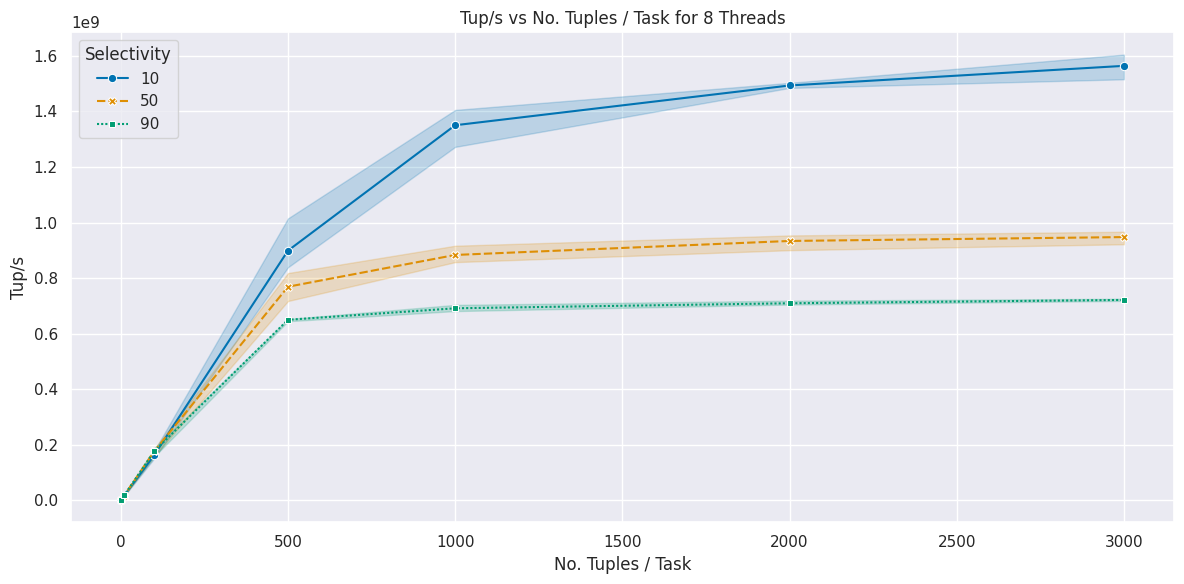

In [16]:
# Load data into dataframe and then plot different boxplots
df = load_data(input_csv_file)
interesting_param = "No. Threads"
time_unit = df.iloc[0]['time_unit']
df = df[df['Provider'] == 1]
#df = df[df['No. Tasks'] < 2000]
x_param="No. Tuples / Task"
df[interesting_param] = pd.to_numeric(df[interesting_param], errors='ignore')
df['Selectivity'] = pd.to_numeric(df['Selectivity'], errors='ignore')


interesting_param_values = [8]
df = df[df[interesting_param].isin(interesting_param_values)]
df = df[df['Selectivity'].isin([10, 50, 90])]
df = df.sort_values(by=[x_param, interesting_param, 'Selectivity'])

# Create a subplot grid.
unique_params = df[interesting_param].unique()
n_params = len(unique_params)
fig, axes = plt.subplots(1, n_params, figsize=(12, 6), squeeze=False, sharey='row')
for idx, param in enumerate(unique_params):
    subset = df[df[interesting_param] == param]

    ax = axes[0][idx]
    sns.lineplot(x=x_param, y="tuples_per_sec", hue='Selectivity', data=subset, ax=ax, palette="colorblind", style="Selectivity", markers=True)
    ax.set_title(f"Tup/s vs {x_param} for {param} Threads")
    ax.set_xlabel(x_param)
    ax.set_ylabel(f"Tup/s")
    #ax.set_ylim(bottom=0)

    #ax = axes[1][idx]
    #sns.lineplot(x=x_param, y="real_time_ms", hue='No. Threads', data=subset, ax=ax, palette="colorblind", style="No. Threads", markers=True)
    #ax.set_title(f"Time vs {x_param} for {param} % Selectivity")
    #ax.set_xlabel(param)
    #ax.set_ylabel(f"Time [ms]")
    #ax.set_yscale('log')
    #ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig(os.path.join(output_folder_plots, f"different_task_sizes_micro_benchmark.pdf"))
plt.show()
plt.close()